In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

PREDICTION_STEPS = 0


In [2]:

# Fetch historical data
def fetch_data(symbol, interval, start, end):
    df = yf.download(tickers=symbol, interval=interval, start=start, end=end)
    df = df[['Close']]
    return df

# Preprocess data
def preprocess_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler

# Create dataset
def create_dataset(data, time_step=60):
    X, Y = [], []
    
    for i in range(len(data) - time_step-PREDICTION_STEPS):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step+PREDICTION_STEPS, 0])
    return np.array(X), np.array(Y)

# Transformer Model using only the encoder
class EncoderOnlyTransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, num_heads, dropout):
        super(EncoderOnlyTransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def create_mask(self, seq_len, device):
        mask = nn.Transformer.generate_square_subsequent_mask(sz=seq_len).to(device)
        return mask
    
    def forward(self, src):
        src = self.fc1(src)
        attention_mask = self.create_mask(src.size(1), src.device)
        output = self.transformer_encoder(src, mask=attention_mask)
        output = self.fc2(output[:, -1, :])
        return output


In [3]:
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
display(device)


/home/lingen/anaconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971214/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

In [4]:

# Hyperparameters
input_dim = 1
hidden_dim = 128
output_dim = 1
num_layers = 6
num_heads = 8
dropout = 0.03
lr = 0.0001
epochs = 10

time_step=60





In [5]:

def parse_date(year, month, day):
    
    if month<10:
        m=f"0{month}"
    else:
        m=f"{month}"

  
    date=f"{year}-"+m+'-'+day

    
    return date



In [6]:
display(parse_date(2024,5,'01'))

'2024-05-01'

In [7]:

list=[('01','08'),
      ('08','15'),
      ('15','22'),
      ('22','27'),
      ('27','28')]

list=[('20','22'),
      ('23','25'),
      ('26','27'),
      ('28','30'),
      ('01','07'),
      ('08','15')]

month=[4,
            4,
            4,
            4,
            5,
            5]

list=[('1','7')]

month=[7]
      


symbol = 'HNT-USD'
interval = '1m'


year =2024



index=0

for dates in list:
    start_day = dates[0]
    end_day = dates[1]

    start_date = parse_date(year, month[index], start_day)
    end_date   = parse_date(year, month[index], end_day)

    print(f" start date: {start_date}  end date: {end_date}")

    print(start_date)
    print(end_date)

    df = fetch_data(symbol, interval, start_date, end_date)
    data, scaler = preprocess_data(df)
    
    X1, Y1 = create_dataset(data, time_step)
    
    if index>1:
      X = np.concatenate((X, X1), axis=0)
      Y = np.concatenate((Y, Y1), axis=0)
      print(X1.shape)
      print(X.shape)
      print(Y1.shape)
      print(Y.shape)
      print('\n')
    else: 
      X=X1
      Y=Y1
 
    index=index+1
    print(index)


    






 start date: 2024-07-1  end date: 2024-07-7
2024-07-1
2024-07-7


[*********************100%%**********************]  1 of 1 completed

1


In [8]:

X = X.reshape(X.shape[0], time_step, input_dim)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.float32).view(-1, 1).to(device)

print(X_train.shape)



torch.Size([5547, 60, 1])


In [9]:

# Initialize model, loss function, and optimizer
model = EncoderOnlyTransformerModel(input_dim, hidden_dim, output_dim, num_layers, num_heads, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [10]:
epoch_loops=2
print(f"transformer_model{epoch_loops}.pth")

transformer_model2.pth


In [11]:

num_loops = 20
# Training loop
for epoch_loops in range(num_loops):

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, Y_train)
        loss.backward()
        optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    # Save the model
    torch.save(model.state_dict(), f"transformer_model89A_{epoch_loops}_mask.pth")
    print(f"Model saved as transformer_model{epoch_loops}.pth")
    

Epoch [1/10], Loss: 4.7273
Epoch [2/10], Loss: 0.4040
Epoch [3/10], Loss: 0.5689
Epoch [4/10], Loss: 1.0263
Epoch [5/10], Loss: 0.7790
Epoch [6/10], Loss: 0.3934
Epoch [7/10], Loss: 0.1294
Epoch [8/10], Loss: 0.0342
Epoch [9/10], Loss: 0.0626
Epoch [10/10], Loss: 0.1382
Model saved as transformer_model0.pth
Epoch [1/10], Loss: 0.1948
Epoch [2/10], Loss: 0.2074
Epoch [3/10], Loss: 0.1764
Epoch [4/10], Loss: 0.1239
Epoch [5/10], Loss: 0.0715
Epoch [6/10], Loss: 0.0368
Epoch [7/10], Loss: 0.0276
Epoch [8/10], Loss: 0.0402
Epoch [9/10], Loss: 0.0635
Epoch [10/10], Loss: 0.0809
Model saved as transformer_model1.pth
Epoch [1/10], Loss: 0.0883
Epoch [2/10], Loss: 0.0809
Epoch [3/10], Loss: 0.0642
Epoch [4/10], Loss: 0.0445
Epoch [5/10], Loss: 0.0290
Epoch [6/10], Loss: 0.0212
Epoch [7/10], Loss: 0.0223
Epoch [8/10], Loss: 0.0284
Epoch [9/10], Loss: 0.0361
Epoch [10/10], Loss: 0.0407
Model saved as transformer_model2.pth
Epoch [1/10], Loss: 0.0409
Epoch [2/10], Loss: 0.0357
Epoch [3/10], Loss:

In [33]:

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()
    predictions = scaler.inverse_transform(predictions)
    actual = scaler.inverse_transform(Y_test.numpy())



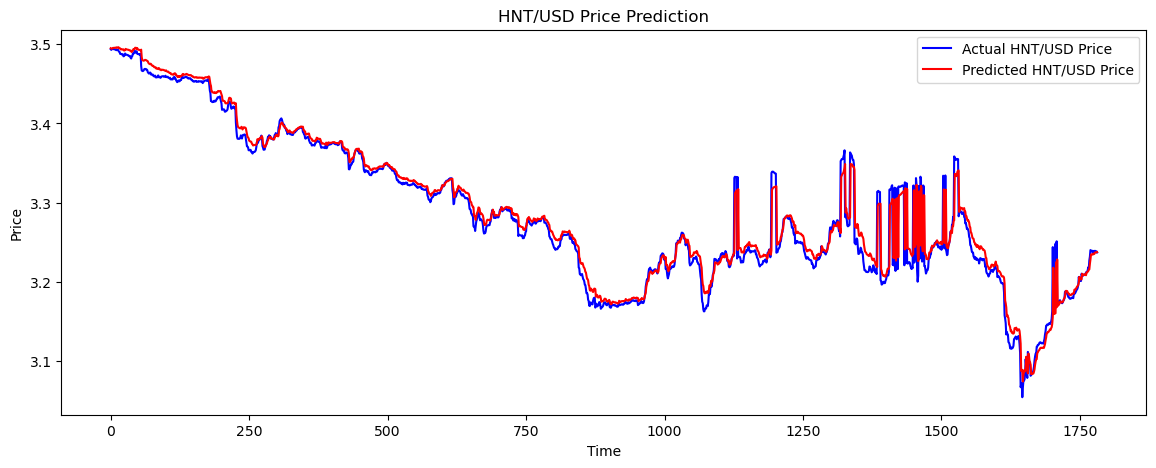

In [34]:

# Plot results
plt.figure(figsize=(14, 5))
plt.plot(actual, color='blue', label='Actual HNT/USD Price')
plt.plot(predictions, color='red', label='Predicted HNT/USD Price')
plt.title('HNT/USD Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


1782

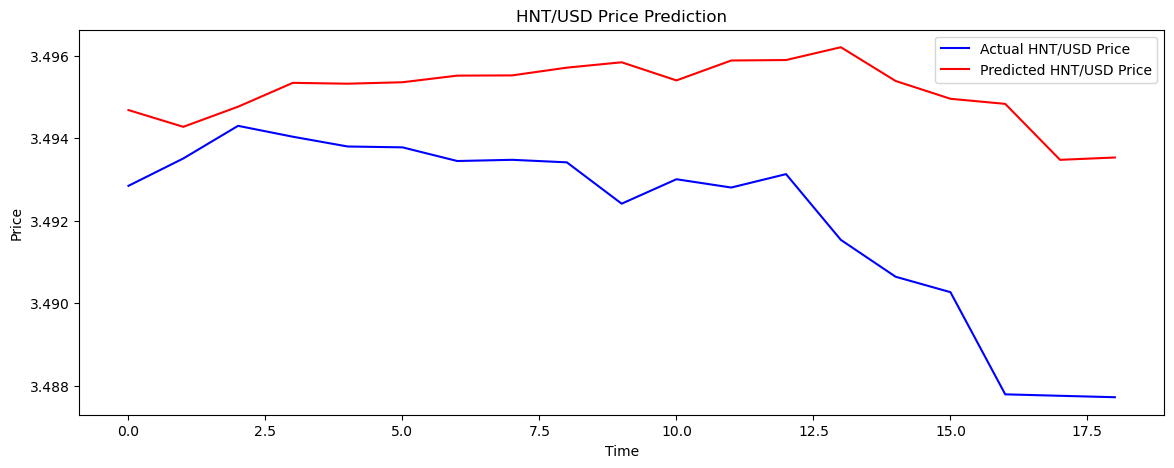

In [36]:
plot_start = 1
plot_end = 20

display(len(actual))

# Plot results
plt.figure(figsize=(14, 5))
plt.plot(actual[plot_start: plot_end], color='blue', label='Actual HNT/USD Price')
plt.plot(predictions[plot_start: plot_end], color='red', label='Predicted HNT/USD Price')
plt.title('HNT/USD Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


1782

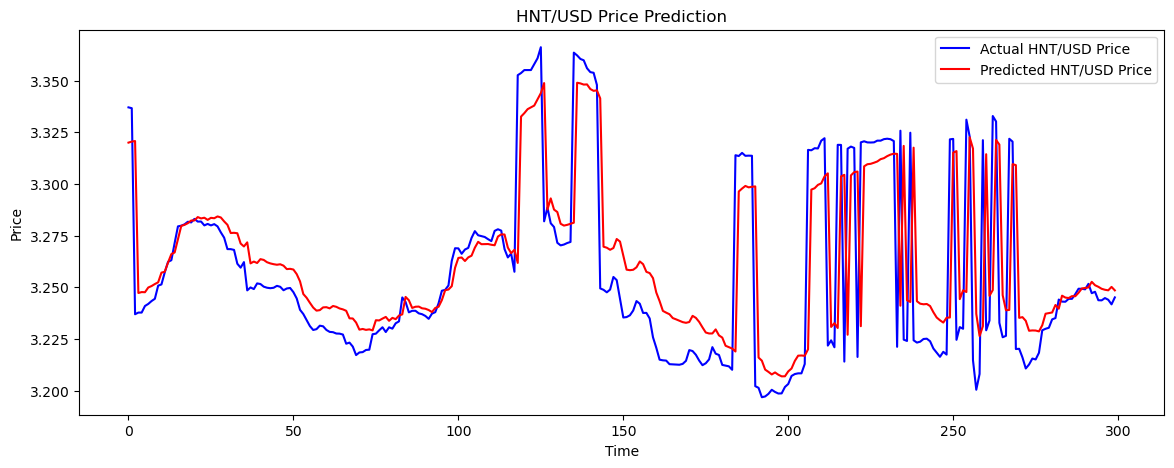

In [37]:
plot_start = 1200
plot_end = 1500

display(len(actual))

# Plot results
plt.figure(figsize=(14, 5))
plt.plot(actual[plot_start: plot_end], color='blue', label='Actual HNT/USD Price')
plt.plot(predictions[plot_start: plot_end], color='red', label='Predicted HNT/USD Price')
plt.title('HNT/USD Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [7]:
model = EncoderOnlyTransformerModel(input_dim, hidden_dim, output_dim, num_layers, num_heads, dropout).to(device)
model.load_state_dict(torch.load('transformer_model89A_19.pth'))
model.eval()


EncoderOnlyTransformerModel(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.03, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.03, inplace=False)
    (dropout2): Dropout(p=0.03, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.03, 

In [9]:

# Hyperparameters
input_dim = 1
hidden_dim = 128
output_dim = 1
num_layers = 6
num_heads = 8
dropout = 0.03
lr = 0.0001
epochs = 30

# Fetch data
symbol = 'HNT-USD'
interval = '1m'
start = '2024-07-08'
end = '2024-07-14'
df = fetch_data(symbol, interval, start, end)

# Preprocess data
data, scaler = preprocess_data(df)

# Create dataset
time_step = 60
X1, Y1 = create_dataset(data, time_step)
X1 = X1.reshape(X1.shape[0], time_step, input_dim)
# X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X1_test = torch.tensor(X1, dtype=torch.float32)
Y1_test = torch.tensor(Y1, dtype=torch.float32).view(-1, 1)

[*********************100%%**********************]  1 of 1 completed


In [10]:
# Evaluation
model.eval()
with torch.no_grad():
    predictions1 = model(X1_test).numpy()
    predictions1 = scaler.inverse_transform(predictions1)
    actual1 = scaler.inverse_transform(Y1_test.numpy())



7629

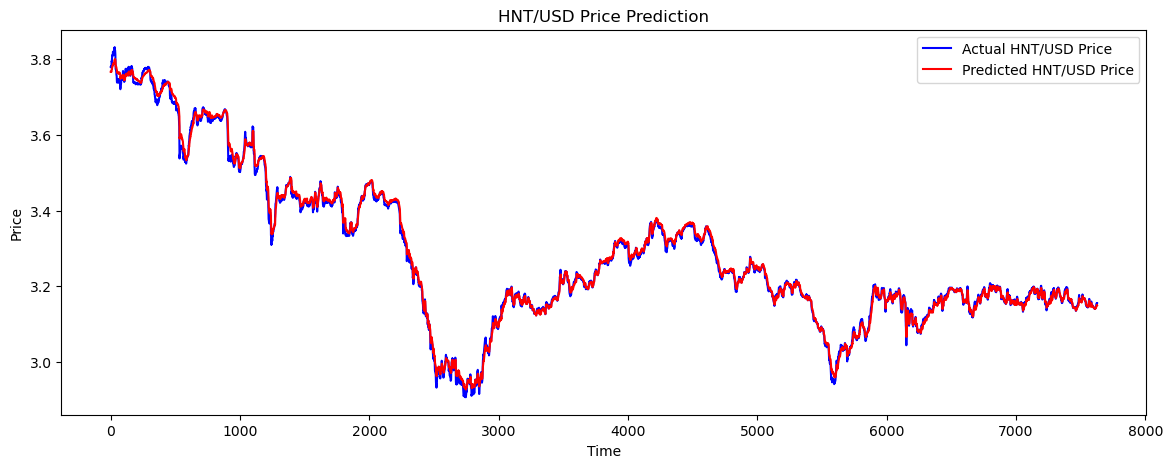

In [11]:
plot_start = 1
plot_end = len(actual1)

display(len(actual1))

# Plot results
plt.figure(figsize=(14, 5))
plt.plot(actual1[plot_start: plot_end], color='blue', label='Actual HNT/USD Price')
plt.plot(predictions1[plot_start: plot_end], color='red', label='Predicted HNT/USD Price')
plt.title('HNT/USD Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

7629

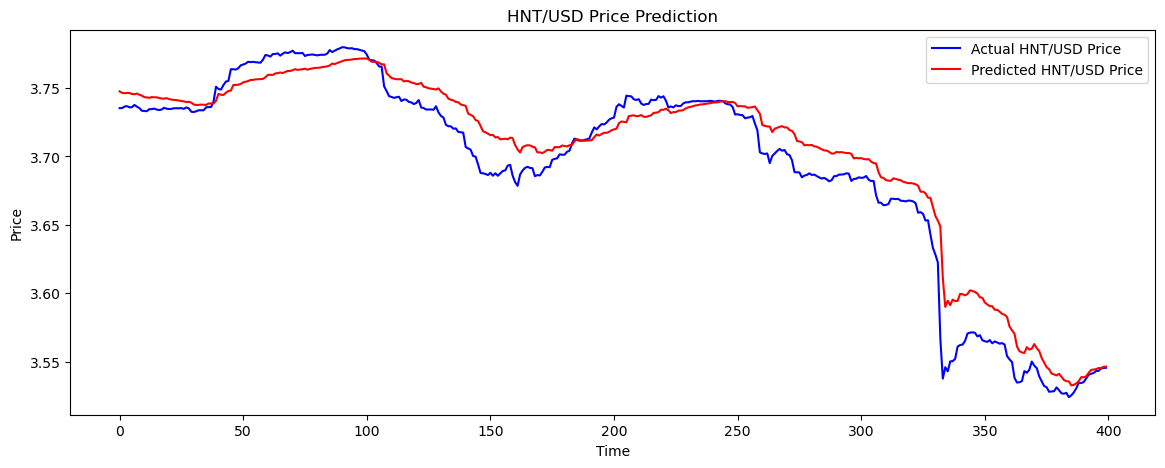

In [12]:
plot_start = 200
plot_end = 600

display(len(actual1))

# Plot results
plt.figure(figsize=(14, 5))
plt.plot(actual1[plot_start: plot_end], color='blue', label='Actual HNT/USD Price')
plt.plot(predictions1[plot_start: plot_end], color='red', label='Predicted HNT/USD Price')
plt.title('HNT/USD Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [13]:
len(actual1)

7629

7629

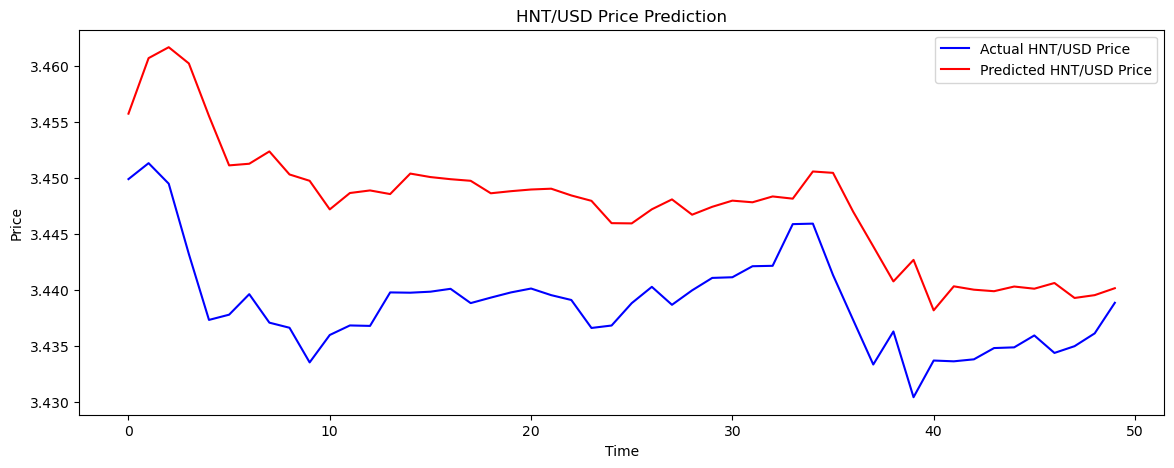

In [14]:
plot_start = 1400
plot_end = 1450

display(len(actual1))

# Plot results
plt.figure(figsize=(14, 5))
plt.plot(actual1[plot_start: plot_end], color='blue', label='Actual HNT/USD Price')
plt.plot(predictions1[plot_start: plot_end], color='red', label='Predicted HNT/USD Price')
plt.title('HNT/USD Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

7629

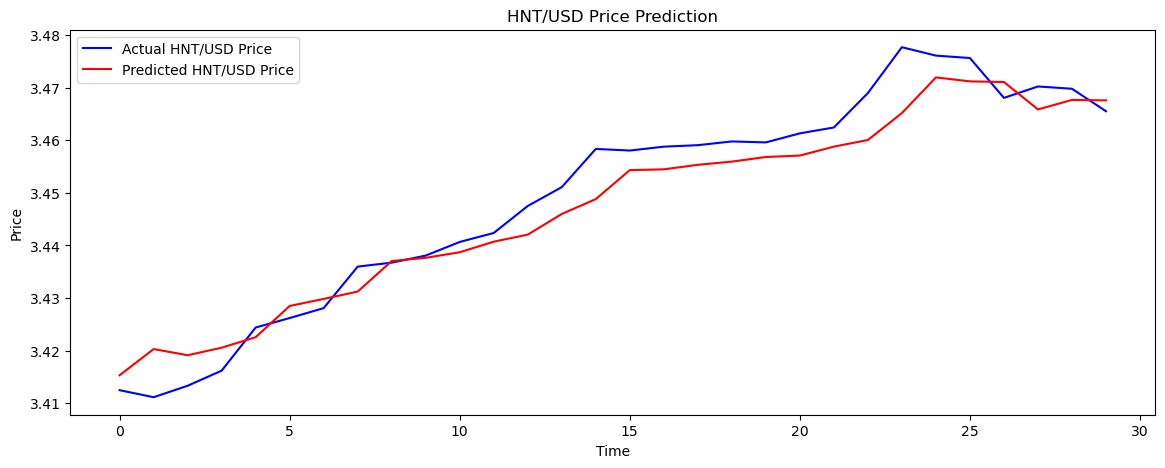

In [15]:
plot_start = 1600
plot_end = 1630

display(len(actual1))

# Plot results
plt.figure(figsize=(14, 5))
plt.plot(actual1[plot_start: plot_end], color='blue', label='Actual HNT/USD Price')
plt.plot(predictions1[plot_start: plot_end], color='red', label='Predicted HNT/USD Price')
plt.title('HNT/USD Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()